Before I use DQN on Tic Tac Toe I want to make sure it really holds up by testing it on a simple gridworld. First, I check if it can do policy evaluation, then I check if it can correctly find the right policy

In [1]:
# For DQN
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# For Experience Replay
from collections import deque
import random

#For Display (illustrator())
from matplotlib import pyplot as plt
import pygame
from pygame.locals import *

signature = 'DQN '

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class board:
    
    def __init__(self, size = 3):
        
        self.player_pos = (0,0)
        self.goal_pos = (size-1, size-1)
        
        self.state = np.zeros((size, size), dtype = np.float32)
        self.state[self.player_pos], self.state[self.goal_pos] = 1, -1
        self.size = size
        
    def update(self, action):
        
        x_dif, y_dif = 0,0.02
        
        if action == 0: # Right
            x_dif = 1
        elif action == 1: # Down
            y_dif = 1
        elif action == 2: # Left
            x_dif = -1
        elif action == 3: # Up
            y_dif = -1
            
        new_coor = (self.player_pos[0] + y_dif, self.player_pos[1] + x_dif)        
        
        if not ((0 <= new_coor[0] < self.size) and (0 <= new_coor[1] < self.size)):
            return 'crash'
        
        self.state[self.player_pos] = 0
        self.player_pos = new_coor
        self.state[self.player_pos] = 1 
        
        if (new_coor[0] == self.size - 1) and (new_coor[1] == self.size -1):
            return 'finish'
        
        return 'move'
        
    def reset(self):
        self.state[self.player_pos] = -1
        self.player_pos = (0,0)
        self.state[self.player_pos] = 1

class game:
    
    def __init__(self, size=3):
        #RL Variables
        self.terminal = False
        self.reward = 0
        
        self.gameboard = board(size)
        
    def update(self, action):                    
        result = self.gameboard.update(action)
            
        if result == 'crash':
            self.reward = -0.02
            
        elif result == 'move':
            self.reward = 0
        
        elif result == 'finish':
            self.reward = 1
            self.terminal = True
                
    def reset(self):
        self.gameboard.reset()
        
        self.terminal = False
        self.reward = 0
    
    def return_state_features(self):
        return self.gameboard.state.reshape(1, -1).copy()
    
    def get_reward(self):
        return self.reward
    
    def get_mask(self):
        return None
    
class illustrator:
    
    def __init__(self, host_game):
        self.host = host_game
    
    def draw(self, state=None):
        if state is not None:
            st = state
        else:
            st = self.host.gameboard.state
        
        print(st.reshape(self.host.gameboard.size, -1))
        
    def end(self):
        pass

class cool_illustrator:
    
    def __init__(self, host_game):
        self.host = host_game
        pygame.init()
        pygame.display.set_caption("GW display")
        self.gameDisplay = pygame.display.set_mode((400,400))
        
    def draw(self, state=None, cs = 20):
        if state is not None:
            st = state
        else:
            st = self.host.gameboard.state
            
        for event in pygame.event.get():
            if event.type == QUIT:
                self.end()
                raise ValueError("Player decided to quit!")
        
        self.gameDisplay.fill((0,0,0))
        end = cs*(self.host.gameboard.size+1)
        for i in range(cs, end+cs, cs):
            pygame.draw.line(self.gameDisplay, (255,255,255), (i, cs), (i, end))
            pygame.draw.line(self.gameDisplay, (255,255,255), (cs, i), (end, i))
        
        ppos = self.host.gameboard.player_pos
        ppos = (ppos[0]*20 + 21, ppos[1]*20 + 21)
        pygame.draw.rect(self.gameDisplay, (0,255,0), (ppos, (20,20)))
        pygame.draw.rect(self.gameDisplay, (255,0,0), (end-19,end-19,20,20))
        pygame.display.update()
        pygame.time.wait(500)
        
    def end(self):
        pygame.quit()


In [4]:
class player:
    def __init__(self):
        self.epsilon = 0
        
    def q_values(self, s):
        return "IS A PLAYER"
    
    def choose_action(self, s):
        return int(input("What direction: "))

In [5]:
class memory_replay:
    
    def __init__(self, max_size):
        
        self.max = max_size 
        self.mem = deque()
    
    def add(self, info_list):
        
        if len(self.mem) < self.max:
            self.mem.append(info_list)
            
        else:
            self.mem.popleft()
            self.mem.append(info_list)
            
    def sample(self, mb_size):
        
        sample_size = min(mb_size, len(self.mem))
        training_set = random.sample(self.mem, sample_size)
        return training_set

In [6]:
class dqn:
    def __init__(self, inp_features, num_actions, epsilon, gamma, decay=0.99999, unfreeze_freq=5000, mem_size=5000, \
                optimizer = keras.optimizers.SGD(learning_rate=0.0009, momentum=0.00007, name="SGD"), loss = keras.losses.MSE):
        
        #Make the trainable variables
        self.epsilon = epsilon
        self.gamma = gamma
        self.decay = decay
        self.min_epsilon = 0.1
        
        self.loss = loss
        self.optimizer = optimizer #alpha should be included in the optimizer
        
        self.num_actions = num_actions
        self.u_freq = unfreeze_freq
        self.counter = unfreeze_freq
        self.memory = memory_replay(mem_size)
        self.gradient_update = []
        
        # Make the network
        inputs = keras.Input(shape=(inp_features,), name="inp")
        x = layers.Dense((inp_features*5//4), activation="relu", name="layer_1")(inputs)
        x = layers.Dense((inp_features*5//6), activation="relu", name="layer_2")(x)
        outputs = layers.Dense(num_actions, activation="tanh", name="q_values")(x)
        self.q_net = keras.Model(inputs=inputs, outputs=outputs)
        self.freeze_net = tf.keras.models.clone_model(self.q_net)
        self.freeze_net.set_weights(self.q_net.get_weights())
    
        def update(q_true, s, mask):
            with tf.GradientTape() as tape:
                pred = self.q_values(s)*mask
                loss = self.loss(q_true, pred)
                loss += sum(self.q_net.losses)

            gradient = tape.gradient(loss, self.q_net.trainable_weights)
            self.optimizer.apply_gradients(zip(gradient, self.q_net.trainable_weights))
            return gradient
            
        inps = (tf.TensorSpec(shape=[None, self.num_actions],dtype=tf.float32), \
                tf.TensorSpec(shape=[None, inp_features],dtype=tf.float32), \
                tf.TensorSpec(shape=[None, self.num_actions], dtype=tf.float32))
        self.update = tf.function(func= update, input_signature= inps)
        

        def q_values(state_features):
            return self.q_net(state_features)

        self.q_values = tf.function(func= q_values, input_signature=(tf.TensorSpec(shape=[None, inp_features],dtype=tf.float32),))

        def q_freeze(state_features):
            return self.freeze_net(state_features)
        
        self.q_freeze = tf.function(func= q_freeze, input_signature=(tf.TensorSpec(shape=[None, inp_features],dtype=tf.float32),))
        
    def choose_action(self, state_features, mask = None):
        
        if self.epsilon > self.min_epsilon:
            self.epsilon*=self.decay
        
        if np.random.rand() < self.epsilon:
            p = np.random.uniform(size=(1,self.num_actions))
            if mask: p*= mask
            return int(p.argmax())
        
        q_values = self.q_values(state_features)
        q_values = (q_values + 1)
        if mask: q_values*mask
        
        return int(tf.argmax(q_values[0]))
        
    def update_normal(self, s, a, r, s2, a2=None, mb_size = 64):
        
        self.memory.add([False, s,a,r,s2,a2])
        self.train_step(mb_size)
        
    def update_final(self, s, a, r, mb_size = 64):
                
        self.memory.add([True, s,a,r])
        self.train_step(mb_size)
        
    def train_step(self, mb_size): 
        
        if self.counter >=1:
            self.counter -=1
        else:
            self.counter = self.u_freq
            self.freeze_net.set_weights(self.q_net.get_weights())
        
        data = self.memory.sample(mb_size)
        
        states = []
        rewards, mask = [np.zeros((len(data), self.num_actions)) for i in range(2)]
        
        for i, step in enumerate(data):
            if step[0]:
                s,a,r = step[1:]
            else:
                s,a,r,s2,a2 = step[1:]
                r+= self.gamma*tf.reduce_max(self.q_freeze(s2)).numpy()
                
            rewards[i, a] = r
            mask[i, a] = 1
            states.append(s.reshape(-1))
            
        q_true = tf.constant(rewards, dtype=tf.float32)
        s = tf.constant(states, dtype=tf.float32)
        mask = tf.constant(mask, dtype=tf.float32)
        grad = self.update(q_true, s, mask)
        
        total_update = 0
        for g in grad:
            total_update += tf.reduce_sum(tf.abs(g))
        self.gradient_update.append(total_update)
        
    def reset_gradient_update(self):
        size = sum(self.gradient_update)
        self.gradient_update = []
        return size
        
    def save(self, filename='sample', adjust = True):
        if adjust: filename = signature + filename
        self.q_net.save(filename)
    
    def load(self, filename='sample', adjust = True):
        if adjust: filename = signature + filename
        self.q_net = keras.models.load_model(filename)
        self.freeze_net = keras.models.load_model(filename)
        

In [62]:
start = time()

size = 10
training_eps, expec_steps = 1250, int((size**(10/3))/4)
steps_list = []
grads_list = []
decay = (0.1)**(1/(training_eps*expec_steps)) #min_epsilon = 0.1

b = game(size)
agent = dqn(size**2, 4, 1, 0.8, decay=decay, optimizer=keras.optimizers.SGD(learning_rate=0.0009, momentum=0.00007, name="SGD"))

for ep in range(1, training_eps+1):
            
    s1, m = b.return_state_features(), b.get_mask()
    a1 = agent.choose_action(s1, m) 
    b.update(a1)
    r1 = b.get_reward()
     
    remember = [(s1, a1, r1)]
    steps = 1

    while not b.terminal:

        s, m = b.return_state_features(), b.get_mask()
        a = agent.choose_action(s)
        b.update(a)
        r = b.get_reward()

        sb, ab, rb = remember.pop()
        remember.append((s,a,r))
        agent.update_normal(sb, ab, rb, s, a, mb_size = 20)
        
        steps+=1


    s, a, r = remember.pop()
    agent.update_final(s, a, r, mb_size = 20)
    
    b.reset()
    steps_list.append(steps)
    grads_list.append(agent.reset_gradient_update()/steps)
    
    print(f"{ep} eps are done! Agent epsilon: {agent.epsilon}. Took {steps} steps with update of {grads_list[-1]}   ", end='\r')

print("\n")
agent.save('agent_{} for size {}'.format(training_eps, size))
print("\nDone!")

time() - start

300 eps are done! Agent epsilon: 0.1280582042362799. Took 6 steps with update of 5.52569580078125       

INFO:tensorflow:Assets written to: DQN agent_300 for size 3\assets

Done!


57.028404235839844

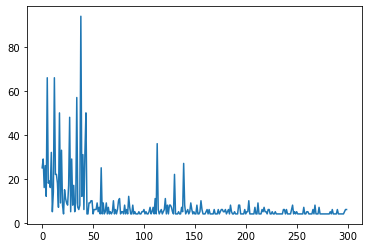

In [63]:
x = np.arange(0,len(steps_list))
y = np.array(steps_list)
plt.plot(x,y)

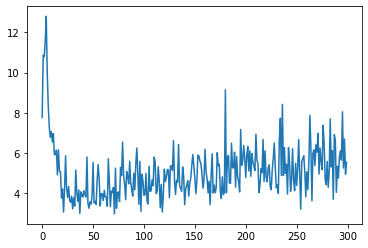

In [64]:
x = np.arange(0,len(grads_list))
y = np.array(grads_list)
plt.plot(x,y)

In [67]:
#Run only if you haven't trained 
size = 15
agent = dqn(size**2, 4, 1, 0.8, decay=0.999, optimizer=keras.optimizers.SGD(learning_rate=0.0009, momentum=0.00007, name="SGD"))
agent.load('DQN Agent_1750 for size 15', adjust = False)

In [68]:
max_steps = 75
b = game(size)
i = cool_illustrator(b)
#agent = player()

init_e1 = agent.epsilon

agent.epsilon = 0

try: 
    steps = 0
    while not b.terminal:
        s = b.return_state_features()
        print(f"agent thinks values are {agent.q_values(s)}")
        i.draw()
        a = agent.choose_action(s)
        b.update(a)
        r = b.get_reward()
        print(f"action was {a} and the reward was {r}\n")
        steps +=1
        if steps> max_steps:
            break
            
except ValueError:
    agent.epsilon = init_e1
    i.end()
    print("Early termination!")

agent.epsilon = init_e1
i.draw()
i.end()

agent thinks values are [[ 0.00286997  0.00371799 -0.0182918  -0.01663   ]]
action was 1 and the reward was 0

agent thinks values are [[ 0.00368113  0.00414504 -0.01713753  0.00371067]]
action was 1 and the reward was 0

agent thinks values are [[ 0.00501819  0.00389402 -0.01563579  0.00312154]]
action was 0 and the reward was 0

agent thinks values are [[0.00576813 0.00483696 0.002561   0.00455831]]
action was 0 and the reward was 0

agent thinks values are [[0.00691423 0.00681    0.00228694 0.00492999]]
action was 0 and the reward was 0

agent thinks values are [[0.00888826 0.00744661 0.00728753 0.00551075]]
action was 0 and the reward was 0

agent thinks values are [[0.01165025 0.00886622 0.0095972  0.01006171]]
action was 0 and the reward was 0

agent thinks values are [[0.01531656 0.01338672 0.00996331 0.00613509]]
action was 0 and the reward was 0

agent thinks values are [[0.01842711 0.01832983 0.01232214 0.01126077]]
action was 0 and the reward was 0

agent thinks values are [

Extras:

Slower version that works! (hasn't been fully updated to optimize with @tf.function(), but when compared to the base current update, its only one or two seconds slower on the batch_64 time test)
<pre>
def train_step(self, mb_size): 

    if self.counter >=1:
        self.counter -=1
    else:
        self.counter = self.u_freq
        self.freeze_net.set_weights(self.q_net.get_weights())

    rewards, index_list, states = [], [], []
    for i, step in enumerate(self.memory.sample(mb_size)):
        if step[0]:
            s,a,r = step[1:]
            rewards.append(r)                
        else:
            s,a,r,s2,a2 = step[1:]
            rewards.append(r+self.gamma*tf.reduce_max(self.q_freeze(s2)).numpy())

        index_list.append([i, a])
        states.append(s.reshape(-1))

    q_true = tf.constant(rewards, dtype=tf.float32)
    s = tf.constant(states)
    self.update(q_true, s, index_list)

def update(self, q_true, s, a):
    with tf.GradientTape() as tape:
        loss = keras.losses.MSE(q_true, tf.gather_nd(self.q_values(s), a))
        loss += sum(self.q_net.losses)

    gradient = tape.gradient(loss, self.q_net.trainable_weights)
    self.optimizer.apply_gradients(zip(gradient, self.q_net.trainable_weights))
</pre>

In [10]:
# Time test! This is what determined which update() method was faster!
# batchsize = 64 

from time import time

bs = 64
tester = dqn(16, 4, 1, 0.8, keras.optimizers.SGD(learning_rate=0.0009, momentum=0.00007, name="SGD"))
for i in range(bs):
    s = np.random.randn(1, 16).astype(np.float32)
    a = 3
    r = 1
    s2 = np.random.randn(1, 16).astype(np.float32)
    a2 = 1
    tester.memory.add([False, s, a, r, s2, a2])

n = 10
total_time = []
for j in range(n):
    start = time()
    for i in range(10):
        tester.train_step(bs)

    total_time.append(time() - start)
    
print(sum(total_time)/n)
print(total_time)

0.7480854272842408
[1.1690220832824707, 0.688694953918457, 0.6713786125183105, 0.6589159965515137, 0.6734054088592529, 0.7180137634277344, 0.7209160327911377, 0.7688870429992676, 0.7271780967712402, 0.6844422817230225]
